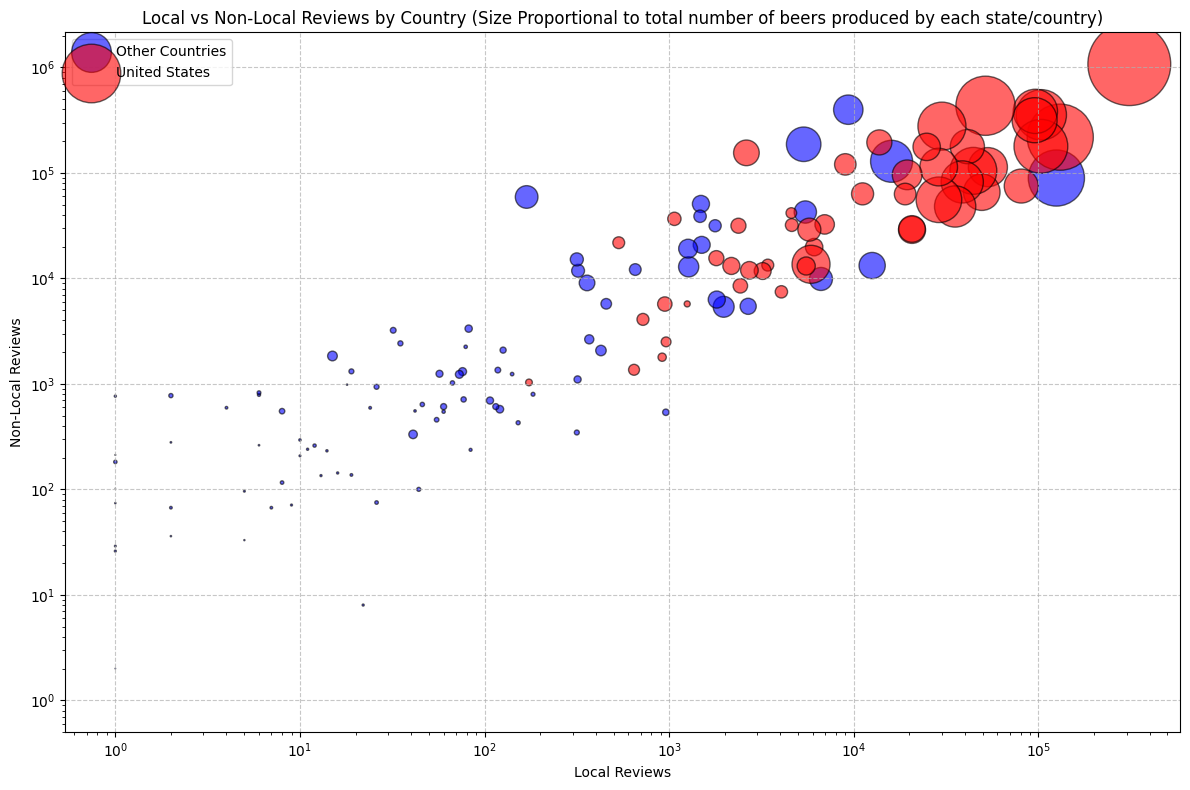

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

#number of beers per location
breweries = pd.read_csv('minimizedData/BA_breweries_small.csv')

#Remove ratings where user_location and beer location is missing (NaN)
#HERE WE WILL remove to refer to the cleaned data from the pipeline!!!
BA_merged = pd.read_csv('minimizedData/BA_ratings_small_plus.csv')
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
BA_merged_cleaned = BA_merged[BA_merged['beer_location'].notna()]

#Local reviews (reviews written by people from one country reviewing beers from that same location)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

#Non-local reviews (reviews written by people for beers from other location)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

#Total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

#Merge the dataframes
country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

#Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

#Sort the DataFrame by the total number of local reviews in ascending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)



fig, ax = plt.subplots(figsize=(12, 8))

#Identify states that are in the US
highlighted = country_data['location'].str.startswith('United States')

#Plot for countries that are NOT 'United States' in blue
scatter = ax.scatter(
    country_data.loc[~highlighted, 'local_reviews'],
    country_data.loc[~highlighted, 'non_local_reviews'],
    s=country_data.loc[~highlighted, 'total_beers'] * 0.1,
    color='blue', 
    alpha=0.6,
    edgecolor='black',
    label='Other Countries'
)

#Plot for US states in red
scatter_us = ax.scatter(
    country_data.loc[highlighted, 'local_reviews'],
    country_data.loc[highlighted, 'non_local_reviews'],
    s=country_data.loc[highlighted, 'total_beers'] * 0.1,
    color='red',
    alpha=0.6,
    edgecolor='black',
    label='United States'
)

# Set plot labels and title
ax.set_xlabel('Local Reviews')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Non-Local Reviews')
ax.set_title('Local vs Non-Local Reviews by Country (Size Proportional to total number of beers produced by each state/country)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper left')
plt.tight_layout()


plt.savefig("modules/3.png")
